In [2]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from enum import Enum


class ArrayPartitionTypes(Enum):
    complete = "complete"
    block = "block"
    cyclic = "cyclic"

@dataclass(frozen=True)
class ArrayPartition:
    variable: str
    dim: int
    type: ArrayPartitionTypes
    factor: int | None = None

@dataclass(frozen=True)
class MemoryOptimization:
    arrayPartition: ArrayPartition

class PipelineStyle(Enum):
    stp = "stp"
    flp = "flp"
    frp = "frp"

@dataclass(frozen=True)
class Pipeline:
    off: bool
    II: int | None = None
    rewind: bool | None = None
    style: PipelineStyle | None = None

@dataclass(frozen=True)
class Unroll:
    off: bool
    factor: int | None = None
    skip_exit_check: bool | None = None

@dataclass(frozen=True)
class Dataflow:
    pass


@dataclass(frozen=True)
class StructureOptimization:
    label: str
    pipeline: Pipeline | None = None
    unroll: Unroll | None = None
    dataflow: Dataflow | None = None


@dataclass(frozen=True)
class OptimizationStrategy:
    memory: list[MemoryOptimization]
    structure: list[StructureOptimization]

@dataclass(frozen=True)
class HLSReport:
    reportName: str
    latency_ns: int
    bram: int
    dsp: int
    ff: int
    lut: int
    uram: int
    taskSpecificInfo: dict[str, any]
    optimizations: OptimizationStrategy

def toDictRepresentation(report: HLSReport):
    result = {
        "ReportName": [report.reportName],
        "M": [report.taskSpecificInfo["M"]],
        "P": [report.taskSpecificInfo["P"]],
        "N": [report.taskSpecificInfo["N"]],
        "Latency_ns": [report.latency_ns],
        "BRAM": [report.bram],
        "DSP": [report.dsp],
        "FF": [report.ff],
        "LUT": [report.lut],
        "URAM": [report.uram],
    }

    variables: list[str] = []
    dim: list[int] = []
    type: list[ArrayPartitionTypes] = []
    factor: list[int | None] = []
    for m in report.optimizations.memory:
        variables.append(m.arrayPartition.variable)
        dim.append(m.arrayPartition.dim)
        type.append(m.arrayPartition.type.name)
        factor.append(m.arrayPartition.factor)

    memory = {
        "ReportName": [report.reportName for i in range(len(variables))],
        "Variables": variables,
        "Dim": dim,
        "Type": type,
        "Factor": factor
    }


    labels: list[str] = []
    optimizationTechniques: list[str] = []
    
    pipelineOff: list[bool | None] = []
    pipelineII: list[int | None] = []
    pipelineRewind: list[bool | None] = []
    pipelineStyle: list[str | None] = []

    unrollOff: list[bool | None] = []
    unrollFactor: list[int | None] = []
    unrollSkipExitCheck: list[bool | None] = []

    for s in report.optimizations.structure:
        labels.append(s.label)

        usedOptimizations: list[str] = []

        if s.dataflow != None:
            usedOptimizations.append("Dataflow")
        if s.pipeline != None:
            usedOptimizations.append("Pipeline")
            pipelineOff.append(s.pipeline.off)
            pipelineII.append(s.pipeline.II)
            pipelineRewind.append(s.pipeline.rewind)
            pipelineStyle.append(s.pipeline.style)
        else:
            pipelineOff.append(None)
            pipelineII.append(None)
            pipelineRewind.append(None)
            pipelineStyle.append(None)


        if s.unroll != None:
            usedOptimizations.append("Unroll")
            unrollOff.append(s.unroll.off)
            unrollFactor.append(s.unroll.factor)
            unrollSkipExitCheck.append(s.unroll.skip_exit_check)
        else:
            unrollOff.append(None)
            unrollFactor.append(None)
            unrollSkipExitCheck.append(None)

        optimizationTechniques.append(str(usedOptimizations))



    optimizations = {
        "ReportName": [report.reportName for i in range(len(labels))],
        "Label": labels,
        "Techniques": optimizationTechniques,
        "Pipeline - Off": pipelineOff,
        "Pipeline - II": pipelineII,
        "Pipeline - Style": pipelineStyle,
        "Pipeline - Rewind": pipelineRewind,
        "Unroll - Off": unrollOff,
        "Unroll - Factor": unrollFactor,
        "Unroll - SkipExitCheck": unrollSkipExitCheck,
    }


    return result, memory, optimizations

def concatDictRepresentation(result0: dict[str, list[any]], memory0: dict[str, list[any]], optimizations0: dict[str, list[any]], result1: dict[str, list[any]], memory1: dict[str, list[any]], optimizations1: dict[str, list[any]]):
    for key, value in result0.items():
        result0[key].extend(result1[key])

    for key, value in memory0.items():
        memory0[key].extend(memory1[key])
    
    for key, value in optimizations0.items():
        optimizations0[key].extend(optimizations1[key])

    return result0, memory0, optimizations0


In [3]:
reports: list[HLSReport] = []

reports.append(HLSReport(
    reportName="Optimization 0",
    latency_ns=164000,
    bram=0,
    dsp=64,
    ff=115,
    lut=1051,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "N": 16,
        "P": 128,
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=True), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 1",
    latency_ns=164000,
    bram=0,
    dsp=128,
    ff=2249,
    lut=1983,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "N": 32,
        "P": 128,
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=True), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 2",
    latency_ns=164000,
    bram=0,
    dsp=256,
    ff=4297,
    lut=3717,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "N": 64,
        "P": 128,
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=True), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 3",
    latency_ns=164000,
    bram=0,
    dsp=512,
    ff=8393,
    lut=7199,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "N": 128,
        "P": 128,
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=True), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 4",
    latency_ns=164000,
    bram=0,
    dsp=1024,
    ff=24826,
    lut=14181,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "N": 256,
        "P": 128,
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=True), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 5",
    latency_ns=164000,
    bram=0,
    dsp=2048,
    ff=48986,
    lut=28095,
    uram=0,
    taskSpecificInfo={
        "M": 128,
        "N": 512,
        "P": 128,
    },
    optimizations=OptimizationStrategy(
        memory=[            
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "mulValue", dim=1, type=ArrayPartitionTypes.complete
            ))],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=True), unroll=Unroll(off=False)
            )
        ]
    )
))

# Note that N = 1024 did not give a usable result as the hardware usage is VERY high and 
# Vitis HLS compiler cannot hit the target clock period of 10 ns since it overshoots!
# With N = 1024 the design is also MASSIVE and complex with the optimizations!


In [ ]:
def PreprocessReport(report: HLSReport):
    prevResult = {}
    prevMemory = {}
    prevOptimizations = {}

    for i in range(len(reports)):
        report = reports[i]

        newResult, newMemory, newOptimizations = toDictRepresentation(report)

        if (i < 1):
            prevResult = newResult
            prevMemory = newMemory
            prevOptimizations = newOptimizations
        else:
            prevResult, prevMemory, prevOptimizations, concatDictRepresentation(prevResult, prevMemory, prevOptimizations, newResult, newMemory, newOptimizations)

    return prevResult, prevMemory, prevOptimizations


def CreateReportDataframes(report: HLSReport):
    prevResult, prevMemory, prevOptimizations = PreprocessReport(report)

    ReportNameCollection = prevResult["ReportName"]
    Result = copy.deepcopy(prevResult)
    Result.pop("ReportName")

    dfResults = pd.DataFrame(Result, index=ReportNameCollection)

    ReportNameCollection = prevMemory["ReportName"]
    Memory = copy.deepcopy(prevMemory)
    Memory.pop("ReportName")

    dfMemory = pd.DataFrame(Memory, index=ReportNameCollection)

    ReportNameCollection = prevOptimizations["ReportName"]
    Optimizations = copy.deepcopy(prevOptimizations)
    Optimizations.pop("ReportName")

    dfOptimizations = pd.DataFrame(Optimizations, index=ReportNameCollection)

    return dfResults, dfMemory, dfOptimizations

In [4]:
prevResult = {}
prevMemory = {}
prevOptimizations = {}

for i in range(len(reports)):
    report = reports[i]

    newResult, newMemory, newOptimizations = toDictRepresentation(report)

    if (i < 1):
        prevResult = newResult
        prevMemory = newMemory
        prevOptimizations = newOptimizations
    else:
        prevResult, prevMemory, prevOptimizations, concatDictRepresentation(prevResult, prevMemory, prevOptimizations, newResult, newMemory, newOptimizations)

In [5]:
ReportNameCollection = prevResult["ReportName"]
Result = copy.deepcopy(prevResult)
Result.pop("ReportName")

dfResults = pd.DataFrame(Result, index=ReportNameCollection)

In [6]:
ReportNameCollection = prevMemory["ReportName"]
Memory = copy.deepcopy(prevMemory)
Memory.pop("ReportName")

dfMemory = pd.DataFrame(Memory, index=ReportNameCollection)

In [7]:
ReportNameCollection = prevOptimizations["ReportName"]
Optimizations = copy.deepcopy(prevOptimizations)
Optimizations.pop("ReportName")

dfOptimizations = pd.DataFrame(Optimizations, index=ReportNameCollection)

In [8]:
# Compute pct resource usage
zcu104 = {
    "LUT": 230400,
    "BRAM": 312,
    "FF": 460800,
    "URAM": 96,
    "DSP": 1728,
}

dfResults["BRAM%"] = dfResults["BRAM"] / zcu104["BRAM"] * 100
dfResults["DSP%"] = dfResults["DSP"] / zcu104["DSP"] * 100
dfResults["FF%"] = dfResults["FF"] / zcu104["FF"] * 100
dfResults["LUT%"] = dfResults["LUT"] / zcu104["LUT"] * 100
dfResults["URAM%"] = dfResults["URAM"] / zcu104["URAM"] * 100

dfResults["(FF + LUT)%"] = ((dfResults["LUT"] / zcu104["LUT"] + dfResults["FF"] / zcu104["FF"]) / 2) * 100

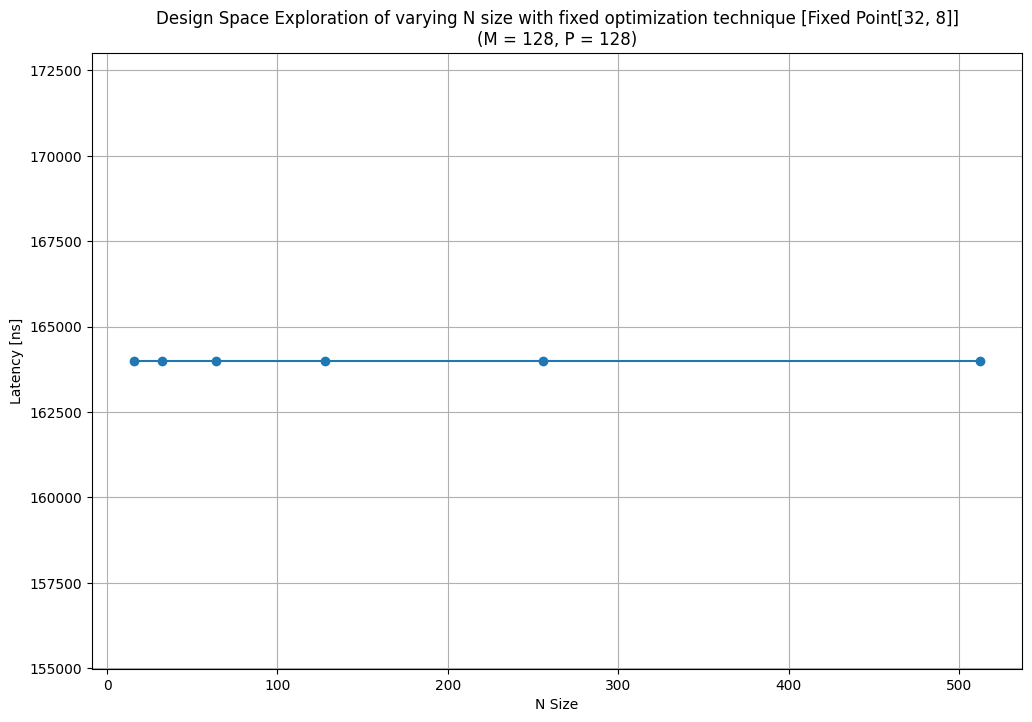

In [23]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

ax.plot(dfResults["N"], dfResults["Latency_ns"], marker="o")

ax.set_xlabel("N Size")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of varying N size with fixed optimization technique [Fixed Point[32, 8]]\n(M = 128, P = 128)")

ax.grid(True)

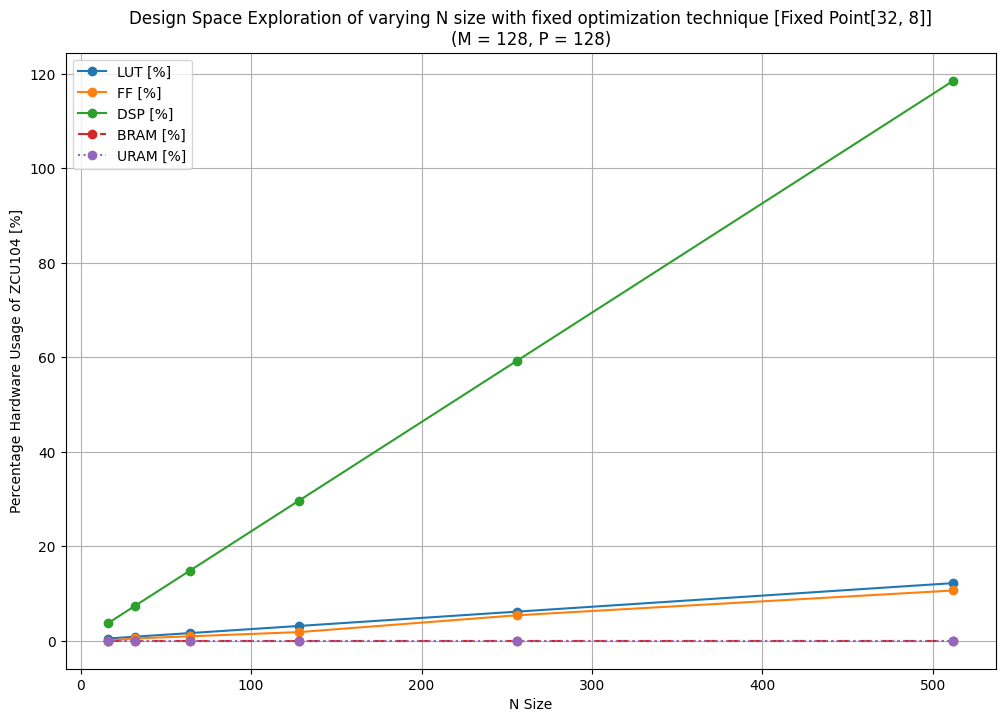

In [22]:
fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handleLUTPct, = ax.plot(dfResults["N"], dfResults["LUT%"], marker="o", label="LUT [%]")
handleFFPct, = ax.plot(dfResults["N"], dfResults["FF%"], marker="o", label="FF [%]")
handleDSPPct, = ax.plot(dfResults["N"], dfResults["DSP%"], marker="o", label="DSP [%]")
handleBRAMPct, = ax.plot(dfResults["N"], dfResults["BRAM%"], marker="o", linestyle="-.", label="BRAM [%]")
handleURAMPct, = ax.plot(dfResults["N"], dfResults["URAM%"], marker="o", linestyle=":", label="URAM [%]")

handles = [handleLUTPct, handleFFPct, handleDSPPct, handleBRAMPct, handleURAMPct]

ax.legend(handles=handles)

ax.set_xlabel("N Size")
ax.set_ylabel("Percentage Hardware Usage of ZCU104 [%]")
ax.set_title("Design Space Exploration of varying N size with fixed optimization technique [Fixed Point[32, 8]]\n(M = 128, P = 128)")

ax.grid(True)

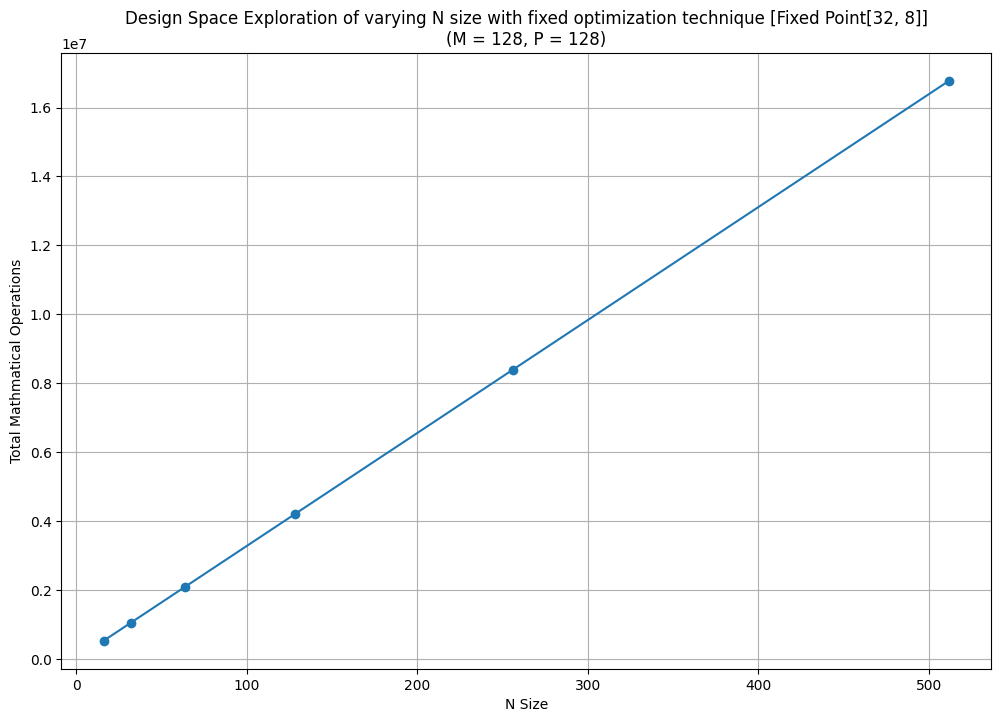

In [30]:
mulOps: list = [0 for i in range(len(dfResults.index))]
sumOps: list = [0 for i in range(len(dfResults.index))]
totalOps: list = [0 for i in range(len(dfResults.index))]
for i in range(len(dfResults.index)):
    mulOps[i] = dfResults["M"].iloc[i] * dfResults["N"].iloc[i] * dfResults["P"].iloc[i]
    sumOps[i] = dfResults["M"].iloc[i] * dfResults["N"].iloc[i] * dfResults["P"].iloc[i]
    totalOps[i] = mulOps[i] + sumOps[i]

dfResults["MulOps"] = mulOps
dfResults["SumOps"] = sumOps
dfResults["TotalOps"] = totalOps

fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

ax.plot(dfResults["N"], dfResults["TotalOps"], marker="o")

ax.set_xlabel("N Size")
ax.set_ylabel("Total Mathmatical Operations")
ax.set_title("Design Space Exploration of varying N size with fixed optimization technique [Fixed Point[32, 8]]\n(M = 128, P = 128)")

ax.grid(True)